In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import time
import pandas as pd
from typing import List, Dict, Tuple, Optional, Any, Callable  # <--- Added Callable here
from dataclasses import dataclass
import numpy.random as rnd

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxIterations, MaxRuntime

In [2]:

# Set random seed for reproducibility
SEED = 2345
np.random.seed(SEED)

@dataclass
class PCTSPData:
    """Data class for a PCTSP instance"""
    instance_id: int
    size: int  # Number of nodes (not including depot)
    depot: np.ndarray  # Depot coordinates [x, y]
    locations: np.ndarray  # Node coordinates [n, 2]
    penalties: np.ndarray  # Penalties for skipping nodes
    prizes: np.ndarray  # Prizes for visiting nodes
    
    @property
    def total_prize(self):
        """The minimum required prize to collect"""
        return 1.0  # As per the problem definition (normalized)
    
    @classmethod
    def from_dict(cls, data_dict):
        """Create a PCTSPData object from a dictionary"""
        return cls(
            instance_id=data_dict['instance_id'],
            size=data_dict['size'],
            depot=data_dict['depot'],
            locations=data_dict['locations'],
            penalties=data_dict['penalties'],
            prizes=data_dict['deterministic_prize']
        )

class PCTSPSolution:
    """Represents a solution to the PCTSP problem"""
    def __init__(self, 
                 tour: List[int], 
                 unvisited: Optional[List[int]] = None):
        """
        Initialize a PCTSP solution
        
        Args:
            tour: List of node indices in the tour (does not include depot)
            unvisited: List of unvisited nodes (if None, will be determined based on the tour)
        """
        self.tour = tour
        if unvisited is None:
            self.unvisited = self._determine_unvisited()
        else:
            self.unvisited = unvisited

    def _determine_unvisited(self) -> List[int]:
        """Determine which nodes are unvisited based on the tour"""
        n = DATA.size
        unvisited = [i for i in range(n) if i not in self.tour]
        return unvisited
    
    def objective(self) -> float:
        """
        Calculate the objective value of the PCTSP solution
        
        Returns:
            Total cost = tour length + penalties for unvisited nodes
        """
        # Initialize tour with depot
        full_tour = [self.tour[i] for i in range(len(self.tour))]
        
        # Calculate tour length
        if not full_tour:
            # If no nodes are visited, the tour length is 0
            tour_length = 0
        else:
            # Distance from depot to first node
            tour_length = np.linalg.norm(DATA.depot - DATA.locations[full_tour[0]])
            
            # Distances between consecutive nodes
            for i in range(len(full_tour) - 1):
                tour_length += np.linalg.norm(
                    DATA.locations[full_tour[i]] - DATA.locations[full_tour[i+1]]
                )
            
            # Distance from last node back to depot
            tour_length += np.linalg.norm(DATA.locations[full_tour[-1]] - DATA.depot)
        
        # Calculate penalties for unvisited nodes
        penalty_cost = sum(DATA.penalties[i] for i in self.unvisited)
        
        return tour_length + penalty_cost
    
    def total_prize(self) -> float:
        """Calculate the total prize collected in the tour"""
        return sum(DATA.prizes[i] for i in self.tour)
    
    def is_feasible(self) -> bool:
        """Check if the solution satisfies the total prize constraint"""
        return self.total_prize() >= DATA.total_prize
    
    def insert(self, node: int, idx: int):
        """Insert a node at the specified index in the tour"""
        self.tour.insert(idx, node)
        if node in self.unvisited:
            self.unvisited.remove(node)
    
    def remove(self, node: int):
        """Remove a node from the tour"""
        self.tour.remove(node)
        self.unvisited.append(node)


In [3]:

def construct_initial_solution(use_greedy: bool = True) -> PCTSPSolution:
    """
    Construct an initial solution for the PCTSP
    
    Args:
        use_greedy: If True, use a greedy construction heuristic,
                    otherwise construct a random solution
    
    Returns:
        An initial PCTSP solution
    """
    n = DATA.size
    
    if use_greedy:
        # Calculate prize-to-penalty ratio for each node
        ratios = []
        for i in range(n):
            # Calculate distance from depot
            dist = np.linalg.norm(DATA.depot - DATA.locations[i])
            # Ratio of prize to (penalty + distance)
            ratio = DATA.prizes[i] / (DATA.penalties[i] + dist)
            ratios.append((i, ratio))
        
        # Sort nodes by decreasing ratio
        ratios.sort(key=lambda x: x[1], reverse=True)
        
        # Start with an empty tour
        tour = []
        current_prize = 0
        
        # Add nodes until prize constraint is satisfied
        for i, _ in ratios:
            tour.append(i)
            current_prize += DATA.prizes[i]
            if current_prize >= DATA.total_prize:
                break
        
        # Reorder tour using nearest neighbor
        if tour:
            reordered_tour = [tour[0]]
            remaining = tour[1:]
            
            while remaining:
                current = reordered_tour[-1]
                dists = []
                for i, node in enumerate(remaining):
                    dist = np.linalg.norm(DATA.locations[current] - DATA.locations[node])
                    dists.append((i, dist))
                
                closest_idx, _ = min(dists, key=lambda x: x[1])
                reordered_tour.append(remaining[closest_idx])
                del remaining[closest_idx]
            
            tour = reordered_tour
    else:
        # Randomly select nodes until prize constraint is satisfied
        available = list(range(n))
        np.random.shuffle(available)
        
        tour = []
        current_prize = 0
        
        for i in available:
            tour.append(i)
            current_prize += DATA.prizes[i]
            if current_prize >= DATA.total_prize:
                break
    
    # Create solution and ensure it's feasible
    solution = PCTSPSolution(tour)
    
    # If not feasible, add more nodes
    if not solution.is_feasible():
        available = solution.unvisited.copy()
        np.random.shuffle(available)
        
        while not solution.is_feasible() and available:
            node = available.pop(0)
            solution.insert(node, len(solution.tour))
    
    return solution


In [7]:
         # Number of times to run ALNS for each instance/operator set (for statistical significance)

In [8]:
# Updated run_alns function
def run_alns(data_instance, 
             destroy_operators: List[Callable], 
             repair_operators: List[Callable], 
             n_iterations=1000, 
             runtime=60,
             seed=SEED):
    """
    Run the ALNS algorithm on a PCTSP instance with specified operators.
    
    Args:
        data_instance: The PCTSPData object for the instance.
        destroy_operators: A list of destroy operator functions.
        repair_operators: A list of repair operator functions.
        n_iterations: Maximum number of ALNS iterations.
        runtime: Maximum runtime in seconds (Note: ALNS library uses MaxIterations).
        seed: Random seed for reproducibility.
    
    Returns:
        Tuple[PCTSPSolution, Dict]: The best solution found and statistics.
    """
    global DATA
    DATA = data_instance
    
    # Create initial solution
    initial_solution = construct_initial_solution(use_greedy=True)
    
    # Initialize ALNS with a random number generator
    rng = rnd.default_rng(seed)
    alns = ALNS(rng) 
    
    # Add destroy operators
    for op in destroy_operators:
        alns.add_destroy_operator(op)
    
    # Add repair operators
    for op in repair_operators:
        alns.add_repair_operator(op)
    
    # Set acceptance criterion (simulated annealing)
    accept = SimulatedAnnealing(
        start_temperature=20.0,
        end_temperature=0.01,
        step=0.1, # Note: Step parameter might need tuning based on iterations
        method="exponential"
    )
    
    # Set weight adjustment (roulette wheel)
    num_destroy = len(destroy_operators)
    num_repair = len(repair_operators)
    # Initial scores - adjust if needed, maybe start all equal
    initial_scores = [1] * (num_destroy + num_repair) 
    select = RouletteWheel(
        num_destroy=num_destroy,
        num_repair=num_repair,
        scores=initial_scores,
        decay=0.8 
    )
    
    # Set stopping criterion (using iterations for now)
    # To use MaxRuntime, you'd need to import and use it:
    # from alns.stop import MaxRuntime
    # stopping_criterion = MaxRuntime(runtime) 
    stopping_criterion = MaxIterations(n_iterations)
    
    # Run the algorithm
    start_time = time.time()
    result = alns.iterate(
        initial_solution,
        select,
        accept,
        stopping_criterion
    )
    end_time = time.time()
    solution = result.best_state
    
    # Return the results 
    stats = {
        'objective_value': solution.objective(),
        'prize_collected': solution.total_prize(),
        'time': end_time - start_time,
        # 'iterations': result.statistics.iterations # Changed num_iterations to iterations
    }
    
    return solution, stats


In [9]:

def plot_solution(solution: PCTSPSolution, title: str = "PCTSP Solution"):
    """
    Plot the PCTSP solution
    
    Args:
        solution: Solution to plot
        title: Plot title
    """
    plt.figure(figsize=(10, 10))
    
    # Plot all nodes
    plt.scatter(
        DATA.locations[:, 0], 
        DATA.locations[:, 1],
        c='lightgray', 
        s=50, 
        label='Unvisited nodes'
    )
    
    # Highlight visited nodes
    plt.scatter(
        [DATA.locations[i, 0] for i in solution.tour], 
        [DATA.locations[i, 1] for i in solution.tour],
        c='blue', 
        s=100, 
        label='Visited nodes'
    )
    
    # Mark the depot
    plt.scatter(
        DATA.depot[0], 
        DATA.depot[1],
        c='red', 
        s=200, 
        marker='*', 
        label='Depot'
    )
    
    # Add node indices for visited nodes
    for idx, node in enumerate(solution.tour):
        plt.annotate(
            str(node), 
            (DATA.locations[node, 0], DATA.locations[node, 1]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    # Plot the tour
    if solution.tour:
        # Start from depot
        tour_x = [DATA.depot[0]]
        tour_y = [DATA.depot[1]]
        
        # Add each node in the tour
        for node in solution.tour:
            tour_x.append(DATA.locations[node, 0])
            tour_y.append(DATA.locations[node, 1])
        
        # Return to depot
        tour_x.append(DATA.depot[0])
        tour_y.append(DATA.depot[1])
        
        plt.plot(tour_x, tour_y, 'k-', alpha=0.7)
    
    plt.title(f"{title}\nCost: {solution.objective():.2f}, Nodes: {len(solution.tour)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


In [10]:
# Updated solve_all_instances function
def solve_all_instances(operator_sets: Dict[str, Dict[str, List[Callable]]], 
                        problem_size=20, 
                        n_iterations=1000,
                        n_runs=1):
    """
    Solve all PCTSP instances of a given size using different operator sets.
    
    Args:
        operator_sets: Dictionary containing named sets of operators.
        problem_size: Size of problems to solve (20, 50, or 100).
        n_iterations: Max iterations for ALNS.
        n_runs: Number of times to repeat the ALNS run for each instance/set.
    
    Returns:
        DataFrame with detailed results.
    """
    # Load instances
    filename = f"pctsp_data/pctsp_{problem_size}_20_instances.pkl"
    try:
        with open(filename, 'rb') as f:
            instances = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: Instance file not found at {filename}")
        return pd.DataFrame() # Return empty DataFrame on error
    
    results = []
    
    # Loop through each instance
    for instance_dict in instances:
        instance = PCTSPData.from_dict(instance_dict)
        print(f"Processing Instance {instance.instance_id} (Size {problem_size})...")
        
        # Loop through each operator set
        for set_name, operators in operator_sets.items():
            print(f"  Using Operator Set: {set_name}")
            
            # Check if operator lists are empty (e.g., placeholders)
            if not operators["destroy"] or not operators["repair"]:
                print(f"    Skipping set '{set_name}' due to missing operators.")
                continue

            destroy_ops = operators["destroy"]
            repair_ops = operators["repair"]
            
            # Run ALNS multiple times for statistical robustness
            for run in range(n_runs):
                # Use a different seed for each run but derive it predictably
                run_seed = SEED + instance.instance_id * 100 + list(operator_sets.keys()).index(set_name) * 10 + run
                
                solution, stats = run_alns(
                    instance, 
                    destroy_ops, 
                    repair_ops, 
                    n_iterations=n_iterations,
                    seed=run_seed 
                )
                
                # Record results
                results.append({
                    'instance_id': instance.instance_id,
                    'size': problem_size,
                    'operator_set': set_name,
                    'run': run + 1,
                    'objective_value': stats['objective_value'],
                    'prize_collected': stats['prize_collected'],
                    'time': stats['time'],
                    # 'iterations_run': stats['iterations'] # Record actual iterations
                })
    
    # Create DataFrame with results
    df = pd.DataFrame(results)
    
    return df

# Load a single instance for testing
def load_single_instance(problem_size=20, instance_id=1):
    """
    Load a single PCTSP instance
    
    Args:
        problem_size: Size of the problem (20, 50, or 100)
        instance_id: ID of the instance (1-20)
    
    Returns:
        PCTSPData object
    """
    filename = f"pctsp_data/pctsp_{problem_size}_20_instances.pkl"
    with open(filename, 'rb') as f:
        instances = pickle.load(f)
    
    # Find the instance with the given ID
    for instance_dict in instances:
        if instance_dict['instance_id'] == instance_id:
            return PCTSPData.from_dict(instance_dict)
    
    # If not found, return the first instance
    return PCTSPData.from_dict(instances[0])

def plot_instance(instance):
    """Plot the PCTSP instance"""
    plt.figure(figsize=(10, 10))
    
    # Plot all nodes
    plt.scatter(
        instance.locations[:, 0], 
        instance.locations[:, 1],
        c='blue', 
        s=50, 
        label='Nodes'
    )
    
    # Mark the depot
    plt.scatter(
        instance.depot[0], 
        instance.depot[1],
        c='red', 
        s=200, 
        marker='*', 
        label='Depot'
    )
    
    # Add node indices
    for i in range(instance.size):
        plt.annotate(
            str(i), 
            (instance.locations[i, 0], instance.locations[i, 1]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    # Add prize and penalty information as text
    plt.figtext(0.5, 0.01, f"Node colors represent prize values", ha='center')
    
    plt.title(f"PCTSP Instance - {instance.size} nodes")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



SOLVING PROBLEMS OF SIZE 20
Processing Instance 1 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 2 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 3 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 4 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 5 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 6 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 7 (Size 20)...
  Using Operator Set: GPT4_1
  Using Operator Set: gemini-2-5-pro
  Using Operator Set: claude-3-7
Processing Instance 8 (Size 20)..

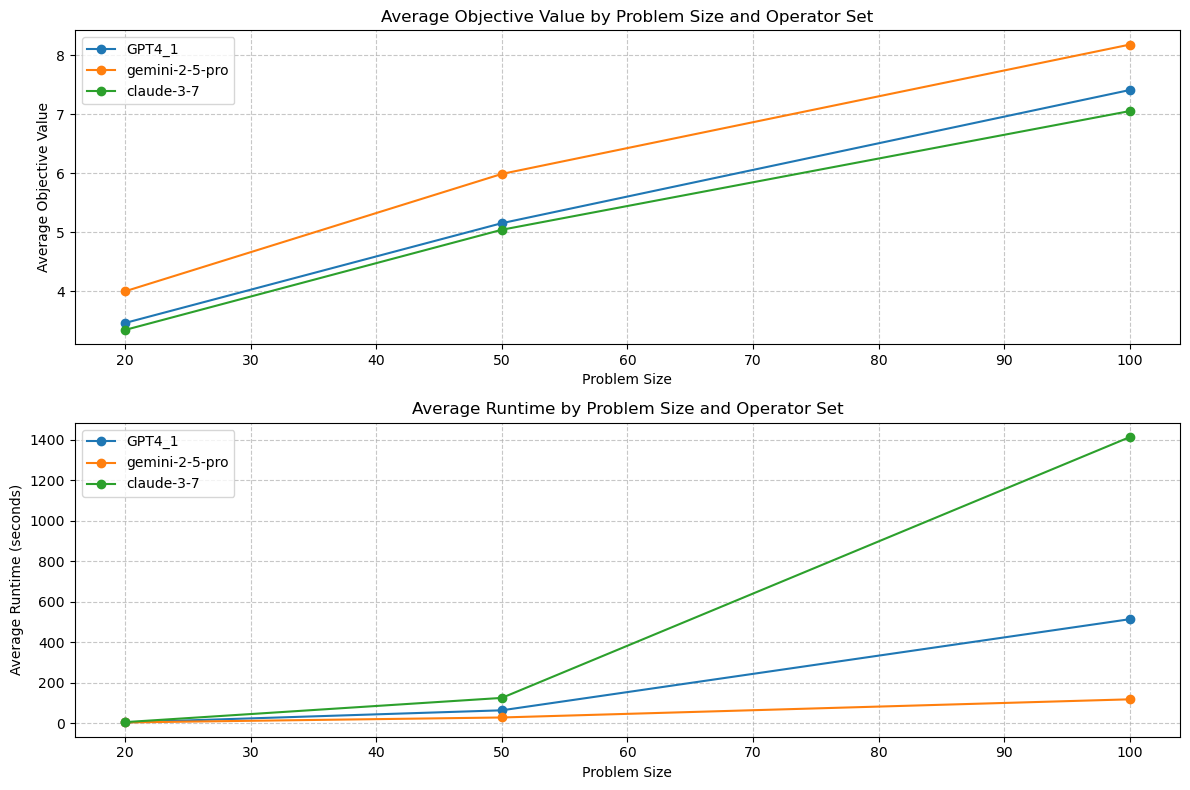

In [11]:
# Updated Main execution part
if __name__ == "__main__":
    
    # --- Run Experiments ---
    # Make sure operator_sets is defined in a previous cell
    # Adjust N_ITERATIONS, PROBLEM_SIZE, N_RUNS in the operator definition cell if needed
    # Run experiments for all problem sizes
    problem_sizes = [20, 50, 100]
    results_all_sizes = []

    for size in problem_sizes:
        print(f"\n{'='*50}")
        print(f"SOLVING PROBLEMS OF SIZE {size}")
        print(f"{'='*50}")
        
        # Solve all instances of this size
        results_df = solve_all_instances(
            operator_sets, 
            problem_size=size, 
            n_iterations=N_ITERATIONS,
            n_runs=N_RUNS
        )
        
        if not results_df.empty:
            # Add identifier for problem size
            results_df['problem_size'] = size
            results_all_sizes.append(results_df)
        else:
            print(f"No results for problem size {size}. Check if the data file exists.")

    # Combine all results
    if results_all_sizes:
        combined_results = pd.concat(results_all_sizes, ignore_index=True)
        
        # Calculate average objective and runtime for each problem size and operator set
        summary_by_size = combined_results.groupby(['problem_size', 'operator_set']).agg(
            avg_objective=('objective_value', 'mean'),
            avg_time=('time', 'mean'),
            num_instances=('instance_id', 'nunique')
        ).reset_index()
        
        # Create a nice formatted table
        print("\n" + "="*80)
        print("SUMMARY OF RESULTS BY PROBLEM SIZE AND OPERATOR SET")
        print("="*80)
        
        # Format the summary table with better formatting
        pd.set_option('display.float_format', '{:.4f}'.format)
        print(summary_by_size)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        
        # Plot average objective values
        plt.subplot(2, 1, 1)
        for op_set in operator_sets.keys():
            subset = summary_by_size[summary_by_size['operator_set'] == op_set]
            if not subset.empty:
                plt.plot(subset['problem_size'], subset['avg_objective'], 'o-', label=op_set)
        
        plt.xlabel('Problem Size')
        plt.ylabel('Average Objective Value')
        plt.title('Average Objective Value by Problem Size and Operator Set')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # Plot average runtimes
        plt.subplot(2, 1, 2)
        for op_set in operator_sets.keys():
            subset = summary_by_size[summary_by_size['operator_set'] == op_set]
            if not subset.empty:
                plt.plot(subset['problem_size'], subset['avg_time'], 'o-', label=op_set)
        
        plt.xlabel('Problem Size')
        plt.ylabel('Average Runtime (seconds)')
        plt.title('Average Runtime by Problem Size and Operator Set')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("No results were generated for any problem size.")

    # --- Optional: Run and plot a single instance with a specific operator set ---
    # set_to_run = 'baseline' 
    # instance_id_to_run = 1
    # if set_to_run in operator_sets and (operator_sets[set_to_run]['destroy'] and operator_sets[set_to_run]['repair']):
    #     print(f"\n--- Running single instance {instance_id_to_run} with '{set_to_run}' operators ---")
    #     single_instance = load_single_instance(problem_size=PROBLEM_SIZE, instance_id=instance_id_to_run)
    #     if single_instance:
    #          destroy_ops = operator_sets[set_to_run]['destroy']
    #          repair_ops = operator_sets[set_to_run]['repair']
    #          solution, stats = run_alns(single_instance, destroy_ops, repair_ops, n_iterations=N_ITERATIONS, seed=SEED)
    #          print(f"Objective: {stats['objective_value']:.4f}, Time: {stats['time']:.4f}s")
    #          # plot_solution(solution, f"Solution with '{set_to_run}' operators (Instance {instance_id_to_run})")
    # else:
    #      print(f"\nCannot run single instance example: Operator set '{set_to_run}' not found or is empty.")
